In [1]:
# Fechas y configuración de warnings
import datetime
import warnings
warnings.filterwarnings("ignore")  

# Visualización
import matplotlib.pyplot as plt  
import numpy as np              
# Machine Learning y optimización
import optuna  
from sklearn.metrics import mean_absolute_error, mean_squared_error  
from sklearn.model_selection import train_test_split 
# Modelos de series temporales
from statsmodels.tsa.arima.model import ARIMA  
from pmdarima import auto_arima  
from prophet import Prophet  
from xgboost import XGBRegressor  

# Fuentes de datos financieros
import yfinance as yf  
import pandas_datareader as pdr  
# Manipulación de datos
import pandas as pd  

In [2]:
#USAMOS PLT PARA ESTILIAR MUCHO MAS LAS GFRÁFICAS UN TOQUE MAS "PROFESIONAL"
plt.style.use('ggplot')
#DESCARGAMOS DATOS HISTÓRICOS DE APPLE (AAPL) 
stock_data = yf.download("AAPL")

# Si las columnas tienen MultiIndex, simplificarlas
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

num_days_pred=30

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
#USAMOS PLT PARA ESTILIAR MUCHO MAS LAS GFRÁFICAS UN TOQUE MAS "PROFESIONAL"
plt.style.use('ggplot')
#DESCARGAMOS DATOS HISTÓRICOS DE APPLE (AAPL) 
stock_data = yf.download("AAPL")

# Si las columnas tienen MultiIndex, simplificarlas
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

num_days_pred=30

[*********************100%***********************]  1 of 1 completed


In [4]:
print(stock_data.columns)


Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [5]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11168 entries, 1980-12-12 to 2025-04-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   11168 non-null  float64
 1   High    11168 non-null  float64
 2   Low     11168 non-null  float64
 3   Open    11168 non-null  float64
 4   Volume  11168 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 523.5 KB


In [6]:
#ESCOJO ÚNICAMENTE LA COLUMNA DE VALORES DE CIERRE
stock_data.drop(columns=['Open', 'High','Low', 'Volume'], inplace=True)

In [7]:
#FUNCIÓN PARA CALCULAR EL PORCENTAJE DE ERROR MEDIO ABSOLUTO (MAE%)

def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el ERROR  PORCENTUAL ABSOLUTO MEDIO (MAE) a partir de valores reales(y_true)
    y los valores predecidos(y_pred) """
    y_true, y_pred= np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100



In [8]:

# Creamos variables rezagadas (lags) de la columna 'Close' para capturar patrones temporales en el modelo

def add_Lags(df, num_days_pred=30):  # Ojo al return al final
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)
    df['lag2'] = df[target].shift(num_days_pred*2)
    df['lag3'] = df[target].shift(num_days_pred*3)
    df['lag4'] = df[target].shift(num_days_pred*4)
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)
    return df  # ← Esto es fundamental




    

In [9]:
# Extraemos características temporales del índice para enriquecer el modelo con contexto estacional y periódico

def create_features(df):
    """
    Creamos características de tiempo basadas en el índice de la serie temporal.
    Esto nos permite incluir información como el mes, día, semana, etc.,
    que puede ser muy útil para detectar patrones estacionales.
    """
    df = df.copy()
    df['hour'] = df.index.hour                # Hora del día
    df['dayofweek'] = df.index.dayofweek      # Día de la semana (0=lunes)
    df['quarter'] = df.index.quarter          # Trimestre del año
    df['month'] = df.index.month              # Mes
    df['year'] = df.index.year                # Año
    df['dayofyear'] = df.index.dayofyear      # Día del año
    df['dayofmonth'] = df.index.day           # Día del mes
    df['weekofyear'] = df.index.isocalendar().week  # Semana del año (ISO)
    return df




<h1 style="color:red;"><strong>XGBOOST</strong></h1>




In [10]:
#Hacemos una copia del modelo 

df_xgb = stock_data.copy()

In [11]:
# Preparamos los datos para el modelo XGBoost: aplicamos transformación temporal y variables
def xgboostmodel(df_xgb, add_lags, create_features, num_days_pred=30):
    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb, num_days_pred=num_days_pred)  # pasar también el parámetro
    df_xgb.dropna(inplace=True)  # Opcional: elimina filas con NaN por los shifts
    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X, y

X, y = xgboostmodel(df_xgb, add_Lags, create_features, num_days_pred=30)

In [12]:
#AHORA VAMOS A DAR PASO A OPTUNA, UNA LIBRERÍA DE OPTIMIZACIÓN AUTOMÁTICA DE HIPERPARÁMETROS BASADA EN LOS MEJORES ENSAYOS
# Define objective function for Optuna
def objective(trial):
    # Definimos los hiperpárametros que se van a optimizar con OPTUNA

    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }

    # Esto inicializa un modelo XGBoost para regresión.
    xgb = XGBRegressor(**param)
    
    # Entrena el modelo con los datos de entrenamiento
    xgb.fit(X_train, y_train)
    
    # Usa el modelo entrenado para predecir valores sobre el conjunto de prueba
    y_pred = xgb.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 #Crear y ejecutar estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Imprimir mejores resultados encontrados
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Entrenar el modelo final con los mejores hiperparámetros
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Predicción y evaluación final
y_pred_test = xgb_best.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)


[I 2025-04-03 17:25:16,772] A new study created in memory with name: no-name-98ec1c76-66f9-49e2-bc56-c37354c735ce
[I 2025-04-03 17:25:17,951] Trial 0 finished with value: 1.2904171883441817 and parameters: {'n_estimators': 941, 'max_depth': 7, 'learning_rate': 0.0992564846922201, 'subsample': 0.9799588379212213, 'colsample_bytree': 0.662940389051155, 'reg_alpha': 8.360494969383854, 'reg_lambda': 0.2555838802445165}. Best is trial 0 with value: 1.2904171883441817.
[I 2025-04-03 17:25:19,157] Trial 1 finished with value: 1.3857076305727323 and parameters: {'n_estimators': 547, 'max_depth': 10, 'learning_rate': 0.05660031820286356, 'subsample': 0.6126561565178265, 'colsample_bytree': 0.9687699051027223, 'reg_alpha': 9.934122780306183, 'reg_lambda': 5.698971826862071}. Best is trial 0 with value: 1.2904171883441817.
[I 2025-04-03 17:25:19,658] Trial 2 finished with value: 1.3956129724755642 and parameters: {'n_estimators': 199, 'max_depth': 8, 'learning_rate': 0.09441174262011862, 'subsamp

Best trial:
  Value: 1.2501313126716733
  Params: 
    n_estimators: 722
    max_depth: 9
    learning_rate: 0.03613485740658645
    subsample: 0.9798327297067682
    colsample_bytree: 0.6449869449755327
    reg_alpha: 0.3743966429152019
    reg_lambda: 0.6061212798502966
Test RMSE: 1.2501313126716733


## EVALUACION

In [13]:
# Evaluamos el rendimiento del modelo XGBoost en el conjunto de test

y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb) 
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 4.602989935743575% 


## REPRESENTACION GRÁFICA DE LOS VALORES


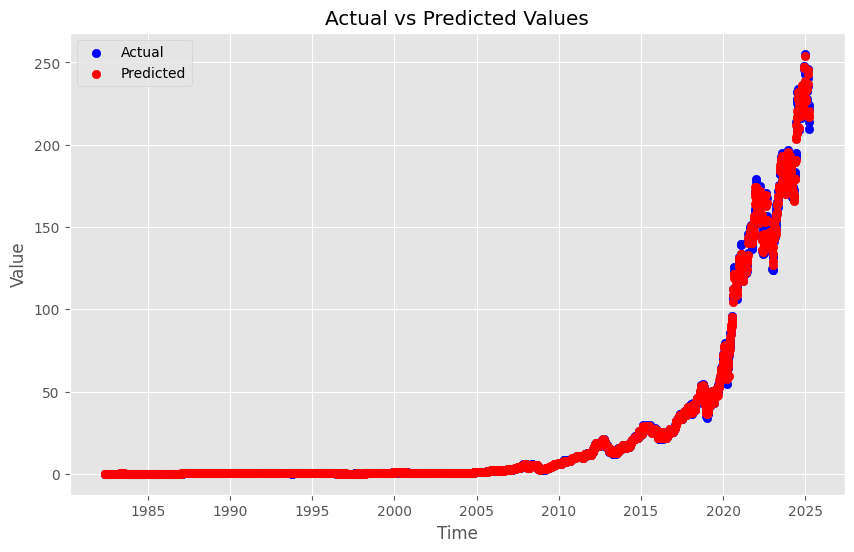

In [14]:
# Visualizamos los valores reales frente a los valores predichos por el modelo XGBoost

plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

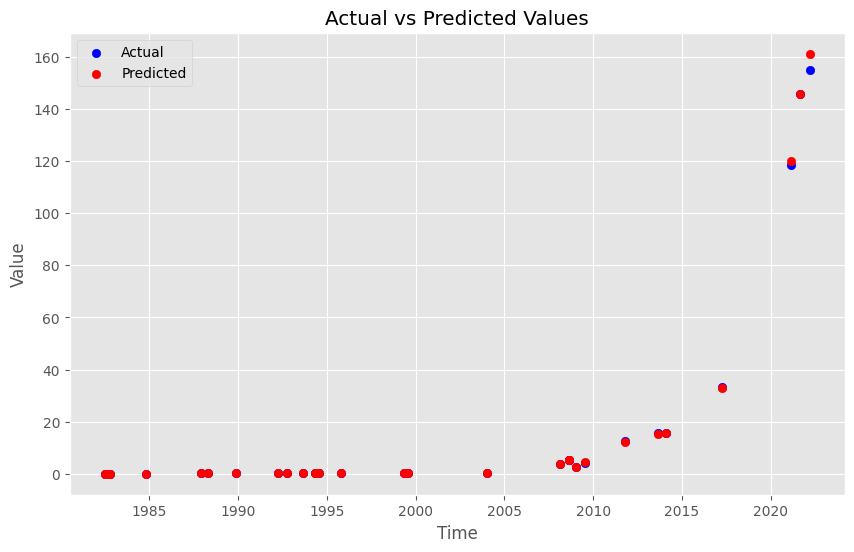

In [15]:
# Hacemos un zoom para visualizar mejor los primeros 30 valores predichos
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

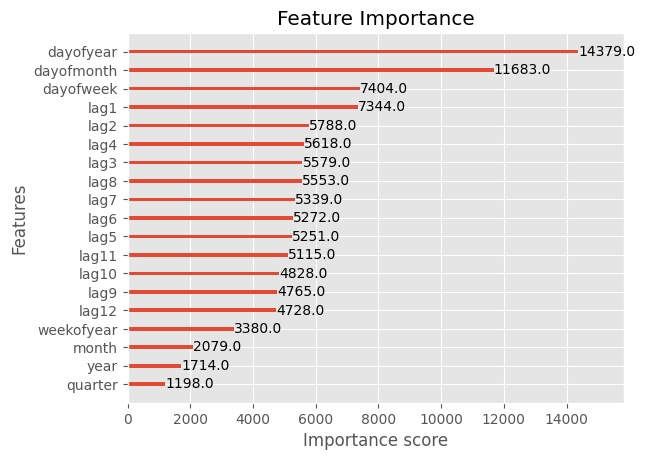

In [16]:
# Visualizamos las 20 características más importantes según el modelo XGBoost


from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()



In [17]:
# Definimos el rango de fechas para hacer predicciones futuras


start = df_xgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

## HACEMOS PREDICCIONES FUTURAS

In [19]:
# Preparamos los datos para Prophet: dividimos en entrenamiento y test, y renombramos columnas a 'ds' y 'y'.


df_prophet = stock_data.copy()

In [20]:
split_date = df_prophet.index[int(len(df_prophet) * 0.8)]
train = df_prophet.loc[df_prophet.index <= split_date].copy()
test = df_prophet.loc[df_prophet.index > split_date].copy()


In [21]:
train_prophet = train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

In [22]:
train_prophet 


Price,ds,y
0,1980-12-12,0.098726
1,1980-12-15,0.093575
2,1980-12-16,0.086707
3,1980-12-17,0.088853
4,1980-12-18,0.091429
...,...,...
8930,2016-05-11,21.171143
8931,2016-05-12,20.674538
8932,2016-05-13,20.715723
8933,2016-05-16,21.484678


In [23]:
prophet = Prophet()
prophet.fit(train_prophet)

17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:37 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Formateamos los datos para usarlos en Prophet renombrando columnas y generamos predicciones con el modelo.

test_prophet = test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
test_predict = prophet.predict(test_prophet)

In [26]:

# Calculamos el error porcentual del modelo Prophet usando MAPE entre valores reales y predichos.

porphet_loss = mean_absolute_percentage_error(test['Close'],test_predict['yhat'] )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test['Close'],test_predict['yhat'] ) }% ")


ERROR PERCENT = 47.73413440858562% 


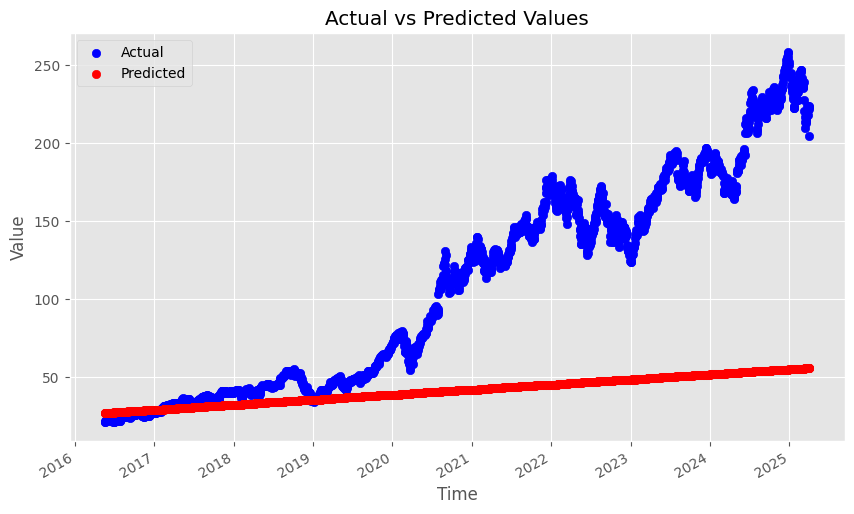

In [27]:
# Asegurarse de que el índice de test sea tipo fecha
test.index = pd.to_datetime(test.index)
test_predict.index = test.index  # Sincroniza el índice con test (si no lo tiene)

# Graficar con fechas reales en eje X
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['Close'], color='blue', label='Actual')
plt.scatter(test.index, test_predict['yhat'], color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.gcf().autofmt_xdate()  # Rotar fechas automáticamente
plt.legend()
plt.show()



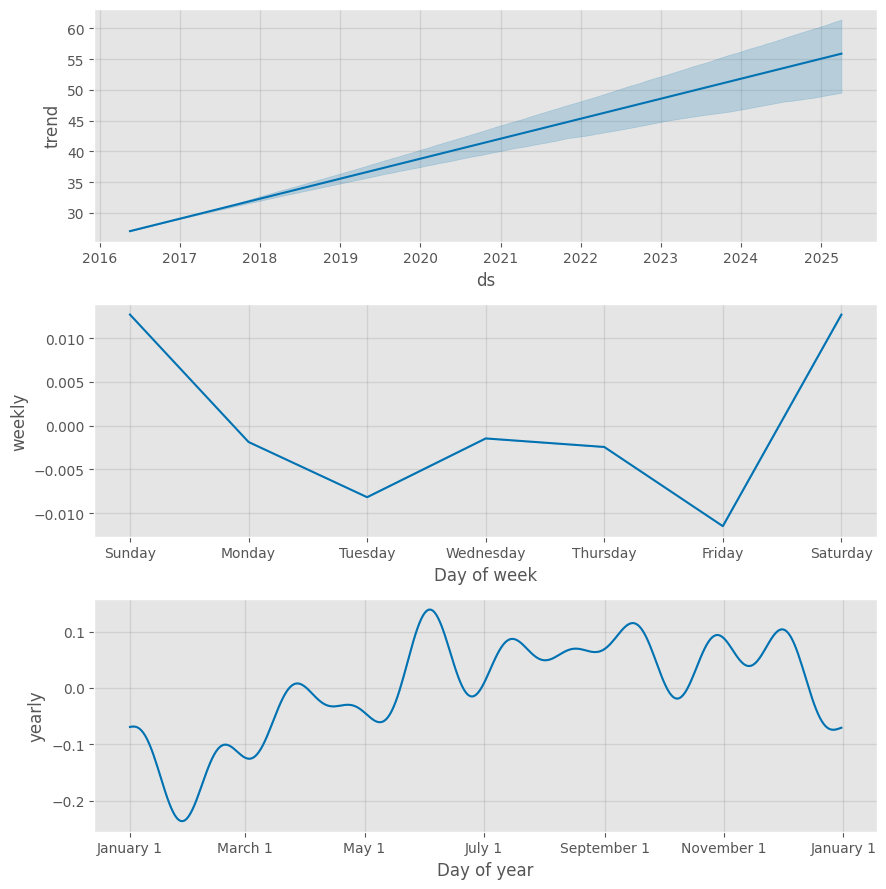

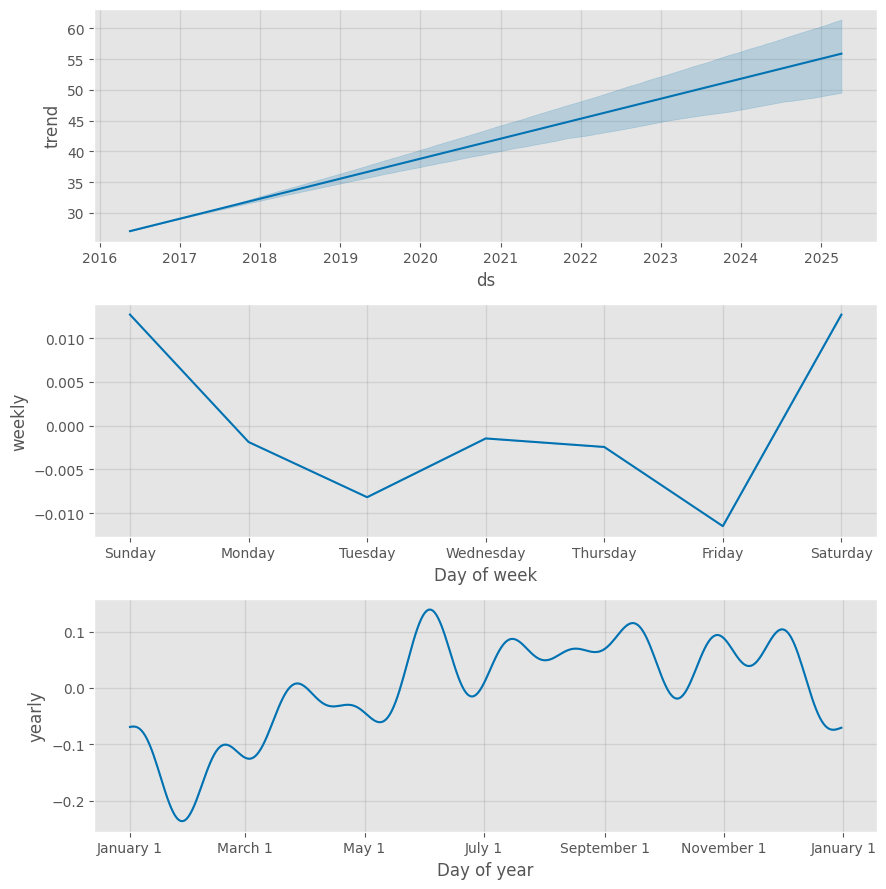

In [ ]:
prophet.plot_components(test_predict)

In [28]:
# Entrenamiento del modelo Prophet con los datos históricos formateados
prophet_data = df_prophet.reset_index() \
    .rename(columns={'Date': 'ds', 'Close': 'y'})
prophet = Prophet()
prophet.fit(prophet_data)


17:31:50 - cmdstanpy - INFO - Chain [1] start processing
17:31:56 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Generamos predicciones futuras con Prophet y reindexamos el resultado por fecha
future = prophet.make_future_dataframe(periods=num_days_pred, freq='d', include_history=False)
forecast = prophet.predict(future) 
forecast_prophet = forecast[['ds', 'yhat']]
forecast_prophet.index = forecast_prophet.pop('ds')


In [30]:
forecast_prophet

,yhat
ds,
2025-04-04,216.851179
2025-04-05,216.964966
2025-04-06,217.034722
2025-04-07,217.118871
2025-04-08,217.194132
2025-04-09,217.237681
2025-04-10,217.267712
2025-04-11,217.303391
2025-04-12,217.400745


<h1 style="color:red;"><strong>ARIMA</strong></h1>

In [31]:
df_arima = stock_data.copy()

In [32]:
split_date = df_prophet.index[int(len(df_arima) * 0.8)]
train_arima = df_arima.loc[df_arima.index <= split_date].copy()
test_arima = df_arima.loc[df_arima.index > split_date].copy()



In [33]:
# Buscamos automáticamente los mejores parámetros para el modelo ARIMA y los guardamos
stepwise_fit = auto_arima(train_arima['Close'], trace=True, suppress_warnings=True)
best_order = stepwise_fit.get_params()['order']


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.96 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-4989.791, Time=0.26 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-7342.176, Time=0.64 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-8403.823, Time=0.37 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-9096.061, Time=0.61 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-9395.384, Time=0.64 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-9698.072, Time=0.86 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=4.80 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=4.21 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-9696.072, Time=2.29 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 17.638 seconds


In [34]:
# Entrenamos el modelo ARIMA con los mejores parámetros encontrados
arima = ARIMA(train_arima['Close'], order=best_order)
arima = arima.fit()


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [35]:
# Definimos el rango de fechas para realizar predicciones con el modelo ARIMA
start = len(train_arima)
end = len(test_arima) + len(train_arima)


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='Date'>

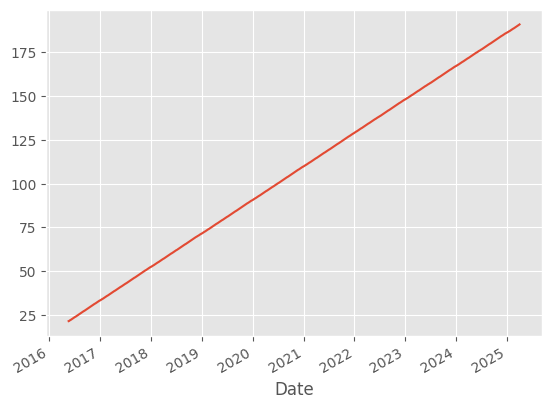

In [36]:
# Realizamos predicción con el modelo ARIMA y visualizamos los resultados
pred_arima = arima.predict(start=start, end=end-1)
pred_arima.index = test_arima.index
pred_arima.plot()


In [37]:
# Calculamos el error porcentual del modelo ARIMA usando MAPE
arima_loss = mean_absolute_percentage_error(test_arima['Close'], pred_arima)
print(f"ERROR PERCENT = { arima_loss }% ")


ERROR PERCENT = 22.98246108530707% 


In [38]:
# Buscamos los mejores parámetros y entrenamos el modelo ARIMA con la serie completa
stepwise_fit = auto_arima(df_arima['Close'], trace=True, suppress_warnings=True)
best_order = stepwise_fit.get_params()['order']

arima = ARIMA(df_arima['Close'], order=best_order)
arima = arima.fit()


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=2.83 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=39031.667, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=35889.153, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=34739.909, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=33887.022, Time=0.34 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=33362.038, Time=0.47 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=33047.068, Time=0.53 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=3.45 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=2.94 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=33049.044, Time=1.15 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 13.087 seconds


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [39]:
start = len(df_arima)
end = len(df_arima) + num_days_pred
arima_forecast = arima.predict(start=start,end=end)

c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [40]:
df_arima.index = pd.to_datetime(df_arima.index)


In [41]:
# Asegúrate que el índice es datetime
df_arima.index = pd.to_datetime(df_arima.index)

# Obtenemos fecha final
start_date = df_arima.index.max()
end_date = start_date + pd.Timedelta(days=num_days_pred)

# Creamos fechas para el forecast
forecast_index = pd.date_range(start=start_date + pd.Timedelta(days=1), end=end_date, freq='1d')

# Predecimos
arima_forecast = arima.predict(start=len(df_arima), end=len(df_arima) + num_days_pred - 1)

# Le damos ese índice de fechas
arima_forecast.index = forecast_index



c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0.5, 1.0, 'Price Prediction in the Next 30 Days')

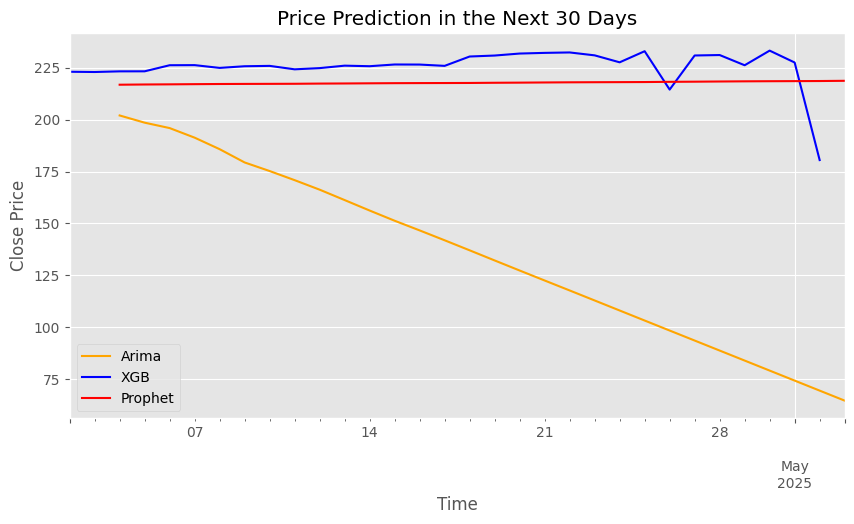

In [ ]:
# Graficamos las predicciones de Arima, XGBoost y Prophet para los próximos días
fig, ax  = plt.subplots(figsize=(10, 5))
arima_forecast.plot(color='orange', ax=ax)
prediction_xgb.plot(color='blue', ax=ax)
forecast_prophet.plot(color='red', ax=ax)
plt.legend(['Arima', 'XGB', 'Prophet'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days")


In [42]:
# Mostramos la precisión (accuracy) de cada modelo restando el MAPE al 100%
print(f"XGB Acc : {100 - xgb_loss} \nArima Acc : {100 - arima_loss} \nProphet Acc : {100 - porphet_loss}")


XGB Acc : 95.39701006425642 
Arima Acc : 77.01753891469293 
Prophet Acc : 52.26586559141438


In [43]:
from joblib import dump

dump(xgb_best, r"C:\Users\anton\SUBIR_EJERCICIOS_THEBRIDGE\EJERCICIOS_THEBRIDGE\PROJECT-BREAK-STOCK/xgb_model.joblib")


['C:\\Users\\anton\\SUBIR_EJERCICIOS_THEBRIDGE\\EJERCICIOS_THEBRIDGE\\PROJECT-BREAK-STOCK/xgb_model.joblib']